In [178]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Desktop/Classes/Research/deep_uncertainty/deep_uncertainty"))

# Bikes Data

Poisson

In [244]:
import pandas as pd

npz = np.load('/Users/braydenchristensen/Desktop/Classes/Research/code/tab-data/bikes.npz')
npz.files
dataframes = {}
for key in npz.files:
    dataframes[key] = pd.DataFrame(npz[key])

X_train = dataframes['X_train']
X_val = dataframes['X_val']
X_test = dataframes['X_test']
y_train = dataframes['y_train']
y_val = dataframes['y_val']
y_test = dataframes['y_test']

print(y_train.shape)
print(X_train.shape)

(13903, 1)
(13903, 15)


In [245]:
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
y_train_pred = poisson_model.predict(X_train)
y_val_pred = poisson_model.predict(X_val)
y_test_preds = poisson_model.predict(X_test)

print(poisson_model.mu)
print(y_train_pred)

[1.05191303e+01 2.32699384e+01 1.12838393e+01 ... 4.95606350e+00
 5.28149288e+02 4.46529704e-01]
0         10.519130
1         23.269938
2         11.283839
3         70.004822
4        159.985689
            ...    
13898    371.566605
13899    816.860507
13900      4.956064
13901    528.149288
13902      0.446530
Length: 13903, dtype: float64


In [246]:
posterior_predictive = poisson(mu=y_test_preds)
posterior_predictive
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[571., 728.],
       [ 21.,  60.],
       [694., 867.],
       [160., 247.],
       [218., 319.],
       [ 52., 106.],
       [282., 395.],
       [ 11.,  42.],
       [  0.,   3.],
       [ 49., 103.]])

In [247]:
len(y_test_preds)

1738

In [248]:
y_test[:10].values

array([[555],
       [ 52],
       [194],
       [229],
       [386],
       [  5],
       [188],
       [126],
       [  3],
       [246]])

array([[<Axes: title={'center': '0'}>]], dtype=object)

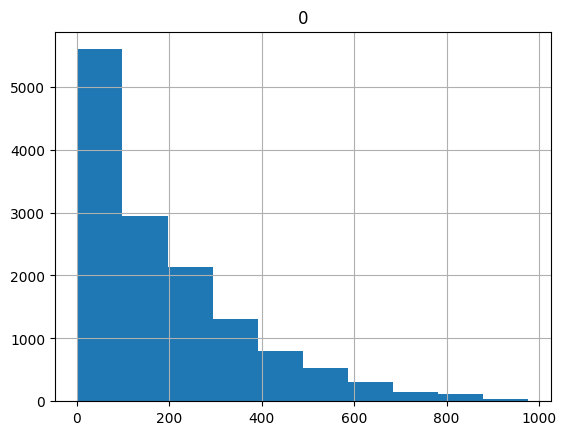

In [249]:
y_train.hist()

In [250]:
np.max(y_train)

977

In [251]:
np.max(y_val)

901

### Metrics

In [252]:
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
val_rmse = np.sqrt(mean_squared_error(y_val_pred, y_val))
rmse = np.sqrt(mean_squared_error(y_test_preds, y_test))
mae = mean_absolute_error(y_test_preds, y_test)


print(f"Train RMSE: {train_rmse}")
print(f"Val RMSE: {val_rmse}\n")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}\n")

Train RMSE: 231.5761137911035
Val RMSE: 229.1017369401325

Test RMSE: 235.27604832162817
Test MAE: 153.5697514258176



Double Poisson NNL

In [253]:
from deep_uncertainty.evaluation.calibration import compute_double_poisson_nll, compute_discrete_ece

y_true = np.array(y_test)
mu = np.array(y_test_preds)
phi = mu
nnl = compute_double_poisson_nll(y_true, mu, phi)
print(f"Double Poisson NNL: {nnl}")

Double Poisson NNL: 42927.80406104178


MP

In [254]:
precisions = 1 / y_test_preds
mp = np.median(precisions)
print(f"Median Precision: {mp}")

Median Precision: 0.022754039681120303


ECE

In [255]:
poisson_predictions = poisson_model.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
lambdas = np.array(predictions_summary_frame['mean'])
from scipy.special import factorial
probs = (np.exp(-lambdas) * (lambdas ** y_test_preds)) / factorial(y_test_preds)

probs = np.nan_to_num(probs)

ece = compute_discrete_ece(np.array(y_test[0]), np.array(y_test_preds), np.array(probs))
print(f"ECE: {ece}")

ECE: 0.1676994081709805


/Users/braydenchristensen/opt/anaconda3/envs/deep-uncertainty/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Negative Binomial

In [256]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from deep_uncertainty.training.losses import neg_binom_nll

class NB_model(nn.Module):
    def __init__(self, input_dim):
        super(NB_model, self).__init__()
        self.linear = nn.Linear(input_dim, 2)
        self.softplus = nn.Softplus()

    def forward(self, x):
        out = self.linear(x)
        return self.softplus(out)

In [285]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

def train(model, optimizer, objective, dataloader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        for x, target in dataloader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = objective(y_pred, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
    return losses

model = NB_model(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
objective = neg_binom_nll
epochs = 100
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
losses = train(model, optimizer, objective, dataloader, epochs)
print("Train loss: ", np.mean(losses[-1000:]))

Train loss:  -771.7480946044922


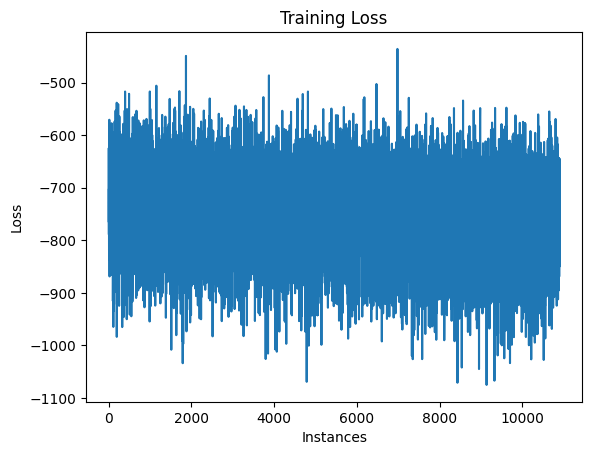

In [286]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Instances')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Testing

In [287]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

model = NB_model(X_train.shape[1])
objective = neg_binom_nll
dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

mu, alpha = model(X_test_tensor).detach().numpy().T

### Metrics

In [288]:
from deep_uncertainty.deep_uncertainty.evaluation import 

rmse = np.sqrt(mean_squared_error(mu, y_test))
mae = mean_absolute_error(mu, y_test)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

Test RMSE: 258.6686222923192
Test MAE: 189.24471763784646


NNL

In [289]:
y_true = np.array(y_test)
variance = mu + (mu**2 / alpha)
phi = mu / variance
nnl = compute_double_poisson_nll(y_true, mu, phi)
print(f"Double Poisson NNL: {nnl}")

Double Poisson NNL: 451.71328249341997


MP

In [290]:
precisions = 1 / variance
mp = np.median(precisions)
print(f"Median Precision: {mp}")

Median Precision: 0.6048341989517212


ECE

In [291]:
p = mu / variance
n = mu**2 / (variance - mu)
k = np.tile(np.arange(0, np.max(y_test)), (len(mu), 1))

probs = nbinom.pmf(k.T, p=p, n=n)

probs = np.nan_to_num(probs)

ece = compute_discrete_ece(np.array(y_test)[:,0], mu, np.array(probs.mean(axis=0)))
print(f"ECE: {ece}")

ECE: 0.0010952902519167575


# Sales Data

Poisson

In [203]:
import pandas as pd

npz = np.load('/Users/braydenchristensen/Desktop/Classes/Research/code/tab-data/sales.npz')
npz.files
dataframes = {}
for key in npz.files:
    dataframes[key] = pd.DataFrame(npz[key])

X_train = dataframes['X_train']
X_val = dataframes['X_val']
X_test = dataframes['X_test']
y_train = dataframes['y_train']
y_val = dataframes['y_val']
y_test = dataframes['y_test']

print(y_train.shape)
print(X_train.shape)

(76421, 1)
(76421, 42)


In [204]:
# X = pd.concat([X_train, X_train, X_val])
# y = pd.concat([y_train, y_train, y_val])

In [205]:
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
y_train_pred = poisson_model.predict(X_train)
y_val_pred = poisson_model.predict(X_val)
y_test_preds = poisson_model.predict(X_test)

# print(poisson_model.mu)
# print(y_train_pred)

In [206]:
posterior_predictive = poisson(mu=y_test_preds)
posterior_predictive
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[ 0., 13.],
       [ 0., 12.],
       [ 0., 13.],
       [ 1., 17.],
       [ 1., 16.],
       [ 0.,  9.],
       [ 0., 14.],
       [ 0., 12.],
       [ 0., 13.],
       [ 2., 22.]])

In [207]:
y_test[:10].values

array([[7.],
       [5.],
       [2.],
       [3.],
       [5.],
       [2.],
       [9.],
       [1.],
       [6.],
       [4.]])

In [208]:
print(y_test_preds)
len(y_test_preds)

0       4.801078
1       4.484918
2       5.137232
3       7.226167
4       7.009805
          ...   
9548    8.416938
9549    6.311879
9550    4.751579
9551    4.190171
9552    4.615769
Length: 9553, dtype: float64


9553

In [209]:
dir(poisson_model)
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      0   No. Observations:                76421
Model:                            GLM   Df Residuals:                    76381
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.3898e+05
Date:                Wed, 17 Apr 2024   Deviance:                   4.4394e+05
Time:                        15:13:17   Pearson chi2:                 4.84e+05
No. Iterations:                    94   Pseudo R-squ. (CS):             0.8479
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1410      0.009     15.178      0.000       0.123       0.159
1              0.7022      0.016     43.221      0.000       0.670       0.734
2              0.4583      0.013     36.332      0.000       0.434       0.483
3              0.1360      0.007     19.280      0.000       0.122       0.150
4           1.419e+05   1.11e+04     12.815      0.000     1.2e+05    1.64e+05
5              0.0340      0.014      2.487      0.013       0.007       0.061
6             -0.1698      0.008    -20.441      0.000      -0.186      -0.154
7             -0.7382      0.117     -6.308      0.000      -0.968      -0.509
8          -2.133e+05   6073.834    -35.117      0.000   -2.25e+05   -2.01e+05
9           -1.63e+05   4640.790    -35.117      0.000   -1.72e+05   -1.54e+05
10         -8.079e+04   8757.424     -9.225      0.000    -9.8e+04   -6.36e+04
11          -2.12e+04   2298.051     -9.225      0.000   -2.57e+04   -1.67e+04
12         -3.165e+05   1.08e+04    -29.222      0.000   -3.38e+05   -2.95e+05
13             0.1917      0.042      4.563      0.000       0.109       0.274
14         -2.133e+05   6073.834    -35.117      0.000   -2.25e+05   -2.01e+05
15          -2.12e+04   2298.051     -9.225      0.000   -2.57e+04   -1.67e+04
16             0.3055      0.020     15.416      0.000       0.267       0.344
17         -1.555e+05   1.21e+04    -12.815      0.000   -1.79e+05   -1.32e+05
18            -0.1819      0.004    -51.385      0.000      -0.189      -0.175
19             0.2517      0.015     17.352      0.000       0.223       0.280
20             0.1680      0.011     15.136      0.000       0.146       0.190
21            -0.2816      0.020    -14.002      0.000      -0.321      -0.242
22             0.2358      0.013     18.570      0.000       0.211       0.261
23             0.2700      0.019     14.427      0.000       0.233       0.307
24             0.3085      0.014     21.533      0.000       0.280       0.337
25          2.919e+05   6213.097     46.989      0.000     2.8e+05    3.04e+05
26          4.149e+05   8829.998     46.990      0.000    3.98e+05    4.32e+05
27          2.967e+05   1.21e+04     24.606      0.000    2.73e+05     3.2e+05
28          2.213e+05   8995.419     24.606      0.000    2.04e+05    2.39e+05
29         -6.279e+05   1.34e+04    -46.990      0.000   -6.54e+05   -6.02e+05
30         -4.556e+05   1.85e+04    -24.606      0.000   -4.92e+05   -4.19e+05
31            10.2582      0.480     21.363      0.000       9.317      11.199
32             0.2856      0.026     10.991      0.000       0.235       0.336
33             0.2315      0.006     36.894      0.000       0.219       0.244
34            -0.0084      0.005     -1.535      0.125      -0.019       0.002
35            -0.3714      0.012    -30.262      0.000      -0.395      -0.347
36

### Metrics

In [210]:
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
val_rmse = np.sqrt(mean_squared_error(y_val_pred, y_val))
rmse = np.sqrt(mean_squared_error(y_test_preds, y_test))
mae = mean_absolute_error(y_test_preds, y_test)


print(f"Train RMSE: {train_rmse}")
print(f"Val RMSE: {val_rmse}\n")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}\n")


Train RMSE: 8.868650403373618
Val RMSE: 8.847541013905643

Test RMSE: 7.845855102977736
Test MAE: 4.567524991652073



Double Poisson NNL

In [211]:
from deep_uncertainty.evaluation.calibration import compute_double_poisson_nll, compute_discrete_ece

y_true = np.array(y_test)
mu = np.array(y_test_preds)
phi = mu
nnl = compute_double_poisson_nll(y_true, mu, phi)
print(f"Double Poisson NNL: {nnl}")

Double Poisson NNL: 35.251579968174994


MP

In [212]:
precisions = 1 / y_test_preds
mp = np.median(precisions)
print(f"Median Precision: {mp}")

Median Precision: 0.16286338598099723


ECE

In [213]:
poisson_predictions = poisson_model.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
lambdas = np.array(predictions_summary_frame['mean'])
from scipy.special import factorial
probs = (np.exp(-lambdas) * (lambdas ** y_test_preds)) / factorial(y_test_preds)

ece = compute_discrete_ece(np.array(y_test[0]), np.array(y_test_preds), np.array(probs))
print(f"ECE: {ece}")

ECE: 0.16112081345554014


In [214]:
probs = (np.exp(-lambdas) * (lambdas ** y_test_preds)) / factorial(y_test_preds)

print(np.array(probs.shape))
print(np.array(y_test_preds.shape))
print(np.array(y_test[0].shape))

[9553]
[9553]
[9553]


Negative Binomial

In [215]:
y_train = y_train.rename(columns={0: 'TARGET'})
y_test = y_test.rename(columns={0: 'TARGET'})

In [216]:
df_train = pd.concat([X_train, y_train], axis=1)

df_train["BB_LAMBDA"] = poisson_model.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['TARGET'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

y_test_preds = nb2_training_results.predict(X_test)
y_val_preds = nb2_training_results.predict(X_val)
y_train_preds = nb2_training_results.predict(X_train)


# Count number of successful predictions
# success_threshold = 1
# test_predictions = np.array(successes)
# y_test_values = y_test.values.flatten()
# absolute_differences = np.abs(test_predictions - y_test_values)
# successful_predictions_count = np.sum(absolute_differences <= success_threshold)
# print("Number of successful predictions:", successful_predictions_count)

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_1809/3826647845.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()


In [217]:
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test

mu = predicted_counts
variances = mu + (mu**2 / aux_olsr_results.params[0])
p = mu / variances
n = (mu **2 / (variances - mu))[0] # all the values are the same
nb_pmf = nbinom(p=p, n=n)
probs = nb_pmf.pmf(y_test_preds)
print(probs)

[0. 0. 0. ... 0. 0. 0.]


/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_1809/2746412796.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variances = mu + (mu**2/aux_olsr_results.params[0])


### Metrics

In [232]:
train_rmse = np.sqrt(mean_squared_error(y_train_preds, y_train))
val_rmse = np.sqrt(mean_squared_error(y_val_preds, y_val))
rmse = np.sqrt(mean_squared_error(y_test_preds, y_test))
mae = mean_absolute_error(y_test_preds, y_test)

print(f"Train RMSE: {train_rmse}")
print(f"Val RMSE: {val_rmse}\n")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

Train RMSE: 9.255150763968368
Val RMSE: 9.283101716314107

Test RMSE: 8.262728212550202
Test MAE: 4.656295301652769


NNL

In [233]:
y_true = np.array(y_test)
mu = np.array(y_test_preds)
alpha = aux_olsr_results.params[0]
variance = mu + (mu**2 / alpha)
phi = mu / variance
nnl = compute_double_poisson_nll(y_true, mu, phi)
print(f"Double Poisson NNL: {nnl}")

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_1809/2625941253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = aux_olsr_results.params[0]


Double Poisson NNL: 3.172944762263457


MP

In [234]:
precisions = 1 / variance
mp = np.median(precisions)
print(f"Median Precision: {mp}")

Median Precision: 0.02487986362853442


ECE

In [235]:
p = mu / variance
n = mu**2 / (variance - mu)
k = np.tile(np.arange(0, np.max(y_test)), (len(mu), 1))

probs = nbinom.pmf(k.T, p=p, n=n)

ece = compute_discrete_ece(np.array(y_test)[:,0], np.array(y_test_preds), np.array(probs.mean(axis=0)))
print(f"ECE: {ece}")

ECE: 0.004739038908089445


In [236]:
np.max(y_test)

211.0

In [223]:
num_examples = 10

In [224]:
k = np.tile(np.arange(0, 100), (num_examples, 1))
p = 0.5
n = 5

In [225]:
n = np.ones(num_examples) * n
p = np.ones(num_examples) * p

In [226]:
probs = nbinom.pmf(k.T, n=n, p=p)

In [227]:
probs.mean(axis=0)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [228]:
probs.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

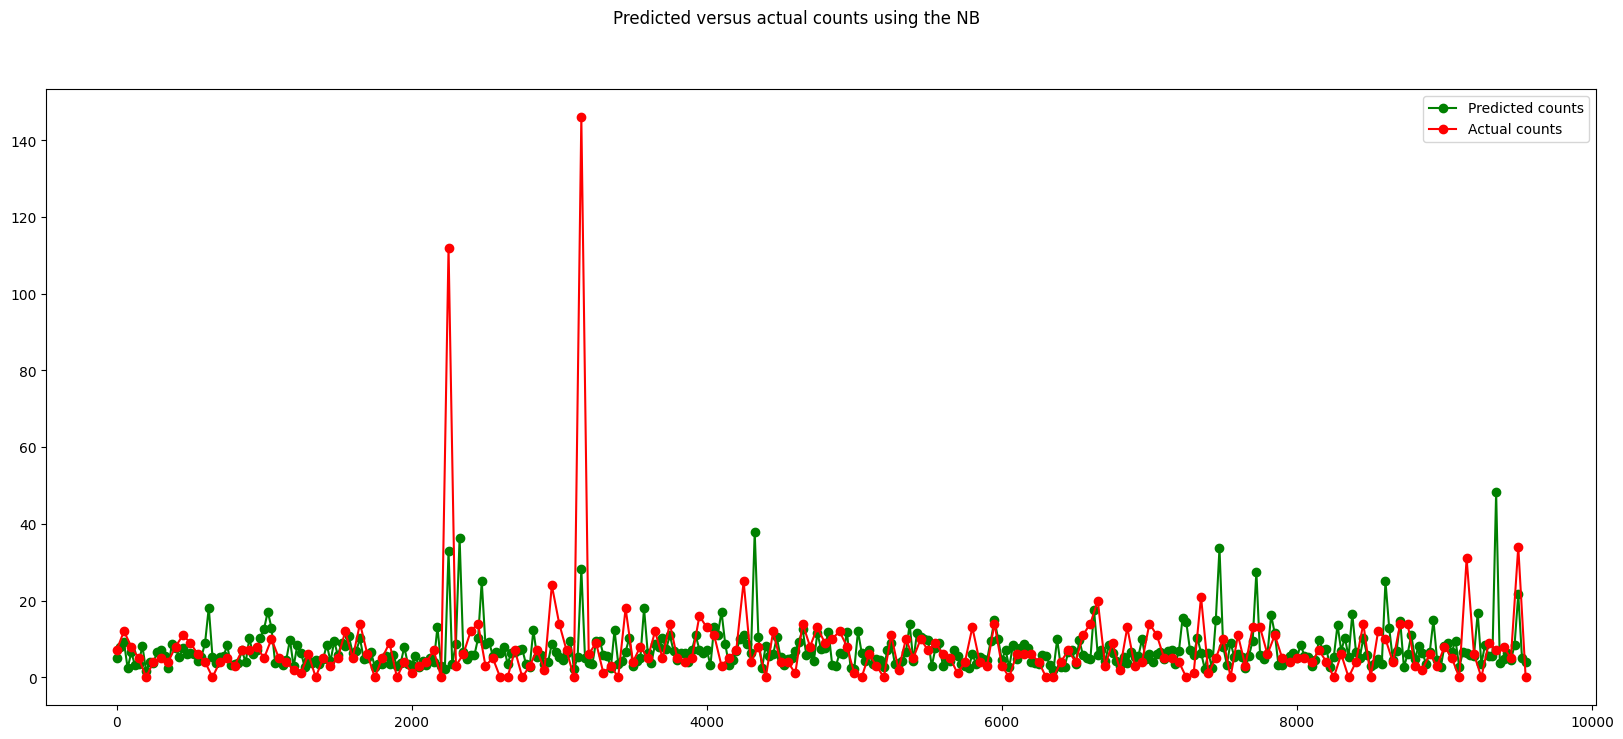

In [229]:
import matplotlib.pyplot as plt
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(20, 8))
fig.suptitle('Predicted versus actual counts using the NB')
predicted_counts1 = predicted_counts[::25]
actual1 = actual_counts[::50]
predicted, = plt.plot(predicted_counts1, 'go-', label='Predicted counts')
actual,  = plt.plot(actual1, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()